## Solving SAT-NAE using (3,1)-QRAC

Suppose we take an easy CNF $(x_1 \lor x_2 \lor \neg x_3) \land (x_1 \lor \neg x_2 \lor x_3)$ (we know it has a solution $[1, 0, 0]$), we can transform this into a graph $G = (V,E)$ with 6 nodes (3 for the variables $x_1$ to $x_3$ and 3 for the variables $\neg x_1$ to $\neg x_3$). Previously, we have shown that it is possible to solve 3SAT-NAE on QAOA, but we will attempt to create a Hamiltonian to solve using QRAO for an arbitrary CNF

### Reading and transforming a CNF into a graph
First we will write a very simple parser for an input CNF formula, and then we will create a graph from that CNF. To make things not complicated, we will consider number variables $0$, $1$, ... so that we don't have too much trouble translating the input into a graph. Since we are treating the 3SAT-NAE case, we will treat this example expression: $\begin{equation}\texttt{0 1 2,0 n1 2}\end{equation}$ as $\begin{equation}(x_1 \lor x_2 \lor x_3) \land (x_1 \lor \neg x_2 \lor x_3)\end{equation}$
For creating the graph, we will use the convention that $\neg x_i$ will be node $x_{i+n}$ in the graph.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from an input CNF formula
def parse_cnf_formula():
    # 1) Used inputs
    num_variables = int(input("Enter the number of variables: "))
    cnf = input("Enter the CNF of the form above (ex: 0 1 2,0 n1 2): ")
    # 2) Separating the CNF into clauses
    clauses = cnf.replace(",", " ")
    individual_variables = clauses.split(" ")
    for i in range(len(individual_variables)):
        if individual_variables[i].startswith("n"):
            individual_variables[i] = str(int(individual_variables[i][1:])+num_variables)
    individual_variables = list(map(lambda elem: int(elem), individual_variables))
    set_of_variables = set(individual_variables)

    G = nx.Graph()
    vertices = list(set_of_variables)
    G.add_nodes_from(vertices)
    for i in range(0, len(individual_variables), 3):
        print('i = ' + str(i))
        G.add_edge(individual_variables[i], individual_variables[i+1], color='b')
        G.add_edge(individual_variables[i], individual_variables[i+2], color='b')
        G.add_edge(individual_variables[i+1], individual_variables[i+2], color='b')

    for i in range(len(individual_variables)):
        if individual_variables[i]+num_variables in set_of_variables:
            G.add_edge(individual_variables[i], individual_variables[i]+num_variables, color='r')


    print(individual_variables)
    
    return G

In [2]:
obtained_graph = parse_cnf_formula()
node_colors = ["lightblue"]*obtained_graph.number_of_nodes()
edge_colors = [obtained_graph[u][v]['color'] for u,v in obtained_graph.edges()]
nx.draw_circular(obtained_graph, with_labels=True, node_color=node_colors, edge_color=edge_colors)

ValueError: invalid literal for int() with base 10: ''

### Graph coloring
Now we color this graph to assign neighboring nodes a different color

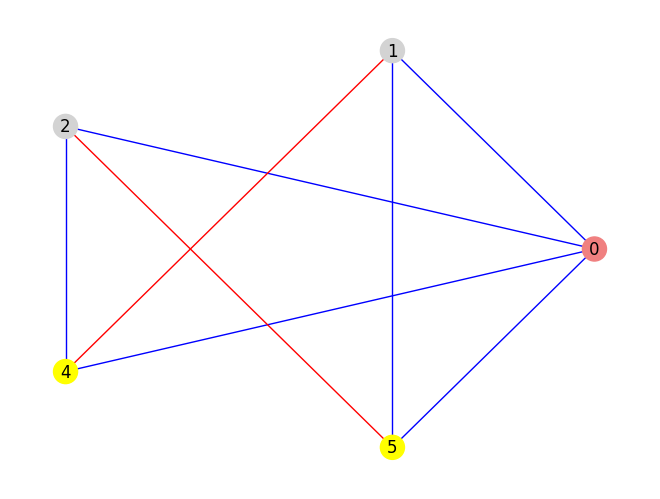

In [26]:
# first set up the colors (add more colors if there are more than 6 variables)
colors_list = ["lightcoral", "lightgray", "yellow", "lime", "lightblue", "green", 
               "mediumaquamarine", "magenta", "lightsteelblue", "chocolate", "darkorange", "moccasin"]

colors = nx.greedy_color(obtained_graph)
new_node_colors = list(map(lambda elem: colors_list[colors[elem]], obtained_graph.nodes))
nx.draw_circular(obtained_graph, with_labels=True, node_color=new_node_colors, edge_color=edge_colors)

In [27]:
# Display the colorings
print(colors)
num_colors = len(set(colors.values()))
print(list(colors.keys()))

{0: 0, 1: 1, 2: 1, 4: 2, 5: 2}
[0, 1, 2, 4, 5]


Now that we got our colored graph, we can transform the colors list into a set of list of vertices $V_{c_i}$ where each set contains vertices of the same color $c_i$. We can do this based off the `colors` variable obtained through greedy graph coloring.

In [28]:
nodes_grouped_by_color = []
for i in range(num_colors):
    nodes_grouped_by_color.append([])
for vertex in obtained_graph.nodes():
    nodes_grouped_by_color[colors[vertex]].append(vertex)
print(nodes_grouped_by_color)

[[0], [1, 2], [4, 5]]


We need $\lceil\frac{|V_c|}{3}\rceil$ qubits for color $c$. So the total number of qubits needed is going to be $\sum\limits_{c \in C}\lceil\frac{|V_c|}{3}\rceil$. In this next cell, we create the qubit mappings, i.e. which qubit corresponds to which Vertex. The way we proceed is greedily assigning qubits to vertices. (https://arxiv.org/pdf/2302.00429.pdf [paper by Kosei Teramoto])

In [29]:
import math

def create_qubit_to_vertices_mapping(nodes_grouped_by_color, bits_per_qubit=3):
    num_qubits_needed = 0
    for i in range(len(nodes_grouped_by_color)):
        num_qubits_needed += math.ceil(len(nodes_grouped_by_color[i])/bits_per_qubit)

    ## qubit q_i maps to a list of vertices associated with qubit q_i (max 3 vertices per qubit)
    qubit_mappings = []

    for elem in nodes_grouped_by_color:
        # this case covers when we need one qubit for a color
        if len(elem) <= bits_per_qubit:
            qubit_mappings.append(elem)
        # this case covers when we need more than one qubit for a color (split the list and assign more than one qubits)
        else:
            first_index = 0
            second_index = bits_per_qubit # slicing the list (i.e. second index will be exluded from the slice)
            while first_index < len(elem):
                # make sure not to go too far in the slice in case the length is not a multiple of 3
                if second_index > len(elem):
                    second_index = len(elem)
                    # append sliced list (max size = bits_per_qubit), i.e. if bpq=3 then for [1,2,3,4,5], we append [1,2,3] and [4,5]
                qubit_mappings.append(elem[first_index:second_index])
                # increase the indices for appending the next element
                first_index += bits_per_qubit
                second_index += bits_per_qubit
    return qubit_mappings

### Print the mappings obtained

In [38]:
qubit_mappings = create_qubit_to_vertices_mapping(nodes_grouped_by_color)    
# Print the qubit -> vertices mappings
print(f"Qubits with vertices: {qubit_mappings}")
for i in range(len(qubit_mappings)):
    print(f"Qubit {i} -> vertices {qubit_mappings[i]}")

Qubits with vertices: [[0], [1, 2], [4, 5]]
Qubit 0 -> vertices [0]
Qubit 1 -> vertices [1, 2]
Qubit 2 -> vertices [4, 5]


### Assign X, Y and Z Pauli operators respectively to each vertex per qubit
We will have a "vertex (index) -> Pauli Operator" mapping, to later construct the Hamiltonian based on this mapping

In [48]:
from qiskit.opflow import X, Y, Z, I

# Maps each vertex to an operator based on the qubit mappings
def create_vertex_to_operator_mapping(qubit_mappings, G):
    mappings = {}

    qrac_3_operators = [X, Y, Z] # Not easy to generalize but we use for (3,1)-QRAC here

    for vertex_groups in qubit_mappings:
        for i in range(len(vertex_groups)):
            mappings[vertex_groups[i]] = qrac_3_operators[i] # assign a different operator per vertex in the same group

    return mappings

### Display the operator assignments for each vertex

In [50]:
# Call the mapping function to create the vertex mapping
vertex_to_operator_mappings = create_vertex_to_operator_mapping(qubit_mappings, obtained_graph)
for i in list(vertex_to_operator_mappings.keys()):
    print(f"Vertex {i} -> {vertex_to_operator_mappings[i]}")

Vertex 0 -> X
Vertex 1 -> X
Vertex 2 -> Y
Vertex 4 -> X
Vertex 5 -> Y


### Create the Hamiltonian based on the operator assignment for each qubit
We know from Teramoto-san's paper (see above), that the max-cut Hamiltonian formulation in this case (for a triangle graph) is the following:
$\begin{equation}
\frac{1}{2}\sum\limits_{(v_i,v_j)\in E(G)}(I - 3P_iP_j)\end{equation}$, where $P_k$ corresponds to the pauli operator assigned to vertex $k$.
Actually this is similar to finding the ground state of $\begin{equation}\sum\limits_{c\in C}(P_iP_j + P_iP_k + P_jP_k) + H_{pen}\end{equation}$.
where $C$ corresponds to the set of clauses of the CNF, $H_{pen}$ is the penalty Hamiltonian of the 3SAT-NAE problem, and $P_l$ is the Pauli operator of vertex $l$ applied on the qubit corresponding to vertex $l$.

To get $H_{pen}$, we can simply replace $Z_iZ_j$ from the original (non-QRAC) Hamiltonian form with $P_iP_j$. Thus our final Hamiltonian for will be given by:
$\begin{equation}\sum\limits_{c\in C}(P_iP_j + P_iP_k + P_jP_k) + M\sum\limits_{v_i \in V(G)} P_{v_i}P_{\neg v_i})\end{equation}$

We will now design this Hamiltonian given an input CNF.

In [16]:
# Let's just import IBMQ here and get the provider since we don't want to run this everytime for subsequent exections
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-utokyo", group="internal", project="hirashi-jst")
backend = provider.get_backend("ibmq_qasm_simulator")

/var/folders/67/92mgzm2n7msbmp1w9k77zjk80000gn/T/ipykernel_47106/2108608613.py:4: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


In [5]:
from qiskit.opflow import X, Y, Z, I

M_FACTOR = 10
num_qubits = 4 # To remove once we can work from an arbitrary CNF

# Create the Problem Hamiltonian

H = (X ^ X ^ I ^ I) + (X ^ I ^ I ^ X) + (I ^ X ^ I ^ X) + (Y ^ I ^ Z ^ I)
H += (Y ^ I ^ I ^ Z) + (I ^ I ^ Z ^ Z) + (Z ^ Y ^ I ^ I) + (Z ^ I ^ X ^ I)
H += (I ^ Y ^ X ^ I) + (I ^ I ^ Y ^ Y) + (I ^ Z ^ Y ^ I) + (I ^ Z ^ I ^ Y)
H += M_FACTOR * ((X ^ I ^ Z ^ I) + (Z ^ X ^ I ^ I) + (Y ^ I ^ I ^ X) + (I ^ Y ^ I ^ Y) + (I ^ Z ^ X ^ I) + (I ^ I ^ Y ^ Z))



In [6]:
# Cell copied from https://qiskit.org/documentation/tutorials/algorithms/05_qaoa.html
from collections import OrderedDict
from qiskit.opflow import StateFn
import numpy as np


def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector (numpy.ndarray or dict): state vector or counts.
    Returns:
        numpy.ndarray: binary string as numpy.ndarray of ints.
    """
    if isinstance(state_vector, (OrderedDict, dict)):
        # get the binary string with the largest count
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    elif isinstance(state_vector, StateFn):
        binary_string = list(state_vector.sample().keys())[0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x

In [7]:
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.algorithms.optimizers import COBYLA

#ANSATZ = EfficientSU2(num_qubits, entanglement="linear", reps=4) # Best so far
#ANSATZ = TwoLocal(num_qubits, "cx", "ry", entanglement="linear", reps=3)
#OPTIMIZER = COBYLA(maxiter=1000)

In [8]:
from qiskit_optimization.runtime import VQEClient
from qiskit import transpile

# num_params = num_qubits * (reps + 1)
#ansatz_opt = transpile(ANSATZ, backend=backend)
#vqe = VQEClient(ansatz=ansatz_opt, optimizer=OPTIMIZER, provider=provider, backend=backend, callback=callback)

#ansatz_opt.draw(fold=300)

In [7]:
#result = vqe.compute_minimum_eigenvalue(H)

In [9]:
#best_parameters = result.optimal_point
#print(best_parameters)

## Recreate Eigenstate

Now that we found the optimal parameters for the circuit, we can recreate $\ket{\Psi(\theta^{(1)}_{opt}, ..., \theta^{(N)}_{opt})}$ using the circuit below.

In [9]:
def circuit_create_eigenstate(optimal_parameters, ansatz_arg, backend):
    ansatz_arg.assign_parameters(optimal_parameters, ansatz_arg.parameters)
    ansatz_opt = transpile(ansatz_arg, backend=backend)
    return ansatz_opt

#eigenstate_creator = circuit_create_eigenstate(best_parameters, ANSATZ, backend)
#eigenstate_creator.draw(fold=300)

## The Global State
We have to remember that, after this circuit is executed, the global quantum state will be close to

$\begin{aligned}
\rho(\textbf{w}) = \frac{1}{2}(I + \frac{(-1)^{w_1}}{\sqrt{3}}X + \frac{(-1)^{w_3}}{\sqrt{3}}Y + \frac{(-1)^{w_8}}{\sqrt{3}}Z) \\
\otimes \frac{1}{2}(I + \frac{(-1)^{w_2}}{\sqrt{3}}X + \frac{(-1)^{w_4}}{\sqrt{3}}Y + \frac{(-1)^{w_{11}}}{\sqrt{3}}Z) \\
\otimes \frac{1}{2}(I + \frac{(-1)^{w_5}}{\sqrt{3}}X + \frac{(-1)^{w_6}}{\sqrt{3}}Y + \frac{(-1)^{w_7}}{\sqrt{3}}Z) \\
\otimes \frac{1}{2}(I + \frac{(-1)^{w_9}}{\sqrt{3}}X + \frac{(-1)^{w_{10}}}{\sqrt{3}}Y + \frac{(-1)^{w_{12}}}{\sqrt{3}}Z) \\
\end{aligned}$

Therefore, in order to get back the weights, we have to measure each qubit in three different bases ($X$, $Y$, and $Z$) in order to get back the bits $\{w_1, \dots, w_{12}\}$.

In total, we therefore need maximum 3 runs on the circuit (multiplied by the number of shots we want).

## Creating the three circuits
We want to create 3 circuits (one for each measurement basis). To measure in the Z basis, we can simply apply the measurement operator since qiskit already measures in the Z basis. For measuring in the X basis, we can apply an H (Hadamard) gate to each qubit, and for measuring in the Y basis, we can apply the S and then the H gate to each qubit.

In [10]:
from qiskit import QuantumCircuit
def create_measurement_circuits(eigenstate_creator, num_qubits):
    circuit_XY = QuantumCircuit(num_qubits, num_qubits)
    circuit_Z = QuantumCircuit(num_qubits, num_qubits)
    circuit_XY.reset(range(num_qubits))
    circuit_Z.reset(range(num_qubits))
    circuit_XY = circuit_XY.compose(eigenstate_creator)
    circuit_Z = circuit_Z.compose(eigenstate_creator)
    circuit_XY.h(list(range(num_qubits)))
    circuit_XY.barrier(range(num_qubits))
    circuit_Z.barrier(range(num_qubits))

    for i in range(num_qubits):
        for circuit in [circuit_XY, circuit_Z]:
            circuit.measure(qubit=i, cbit=i)
    return circuit_XY, circuit_Z

#circuit_XY, circuit_Z = create_measurement_circuits(eigenstate_creator, num_qubits)

In [12]:
#circuit_XY.draw(fold=300, output="mpl")

In [13]:
#circuit_Z.draw(fold=300, output="mpl")

## Getting the results
Now let us run the circuits and fetch the results. But first we need to get an IBMQ backend.

In [11]:
def run_circuits(circuit_XY, circuit_Z, shots, backend):
    jobs = {}
    jobs["XY"] = backend.run(circuit_XY, shots=shots)
    jobs["Z"] = backend.run(circuit_Z, shots=shots)
    return jobs

#jobs = run_circuits(circuit_XY, circuit_Z, 2048, backend)

In [516]:
#for elem in ["XY", "Z"]:
##    counts = jobs[elem].result().get_counts()
#    most_probable = max(counts, key=counts.get)
 #   print(f"{elem} basis => {most_probable}")

In [494]:
#countsXY = jobs["XY"].result().get_counts()
#countsZ = jobs["Z"].result().get_counts()
#[x1, x2, x5, Nx3] = list(map(lambda elem: int(elem), max(countsXY, key=countsXY.get)))
#[x3, x4, x6, Nx4] = [x1, x2, x5, Nx3]
#[Nx2, Nx5, Nx1, Nx6] = list(map(lambda elem: int(elem), max(countsZ, key=countsZ.get)))

In [23]:
def calculate_error(x1, x2, x3, x4, x5, x6, Nx1, Nx2, Nx3, Nx4, Nx5, Nx6):
    satnae_error = 0
    # If not satisfies clauses
    if x1 + x2 + Nx3 == 0 or x1 + x2 + Nx3 == 3:
        satnae_error += 1
    if x3 + Nx1 + Nx6 == 0 or x3 + Nx1 + Nx6 == 3:
        satnae_error += 1
    if Nx2 + x4 + x5 == 0 or Nx2 + x4 + x5 == 3:
        satnae_error += 1
    if Nx4 + Nx5 + x6 == 0 or Nx4 + Nx5 + x6 == 3:
        satnae_error += 1
    consistency_error = 0
    consistency_error += (x1 == Nx1) + (x2 == Nx2) + (x3 == Nx3) + (x4 == Nx4) + (x5 == Nx5) + (x6 == Nx6)
    return satnae_error, consistency_error

In [59]:
from qiskit.algorithms.optimizers import NFT
from qiskit.algorithms import VQE

def run_many_tests(ansatz, m, num_runs, provider, backend):
    num_qubits = 4 # To remove once we can work from an arbitrary CNF

    # Create the Problem Hamiltonian
    probH = (X ^ X ^ I ^ I) + (X ^ I ^ I ^ X) + (I ^ X ^ I ^ X) + (Y ^ I ^ Z ^ I)
    probH += (Y ^ I ^ I ^ Z) + (I ^ I ^ Z ^ Z) + (Z ^ Y ^ I ^ I) + (Z ^ I ^ X ^ I)
    probH += (I ^ Y ^ X ^ I) + (I ^ I ^ Y ^ Y) + (I ^ Z ^ Y ^ I) + (I ^ Z ^ I ^ Y)
    probH += m * ((X ^ I ^ Z ^ I) + (Z ^ X ^ I ^ I) + (Y ^ I ^ I ^ X) + (I ^ Y ^ I ^ Y) + (I ^ Z ^ X ^ I) + (I ^ I ^ Y ^ Z))

    ansatz_opt = transpile(ansatz[1], backend=backend)

    total_satnae_error = 0
    total_consistency_error = 0
    num_successes = 0
    vqe = VQEClient(ansatz=ansatz_opt, optimizer=NFT(maxiter=96), provider=provider, backend=backend)
    for i in range(1):
        print(f"RUN {i+1}")
        result = vqe.compute_minimum_eigenvalue(probH)
        best_parameters = result.optimal_point
        eigenstate_creator = circuit_create_eigenstate(best_parameters, ansatz_opt, backend)
        circuit_XY, circuit_Z = create_measurement_circuits(eigenstate_creator, num_qubits)
        jobs = run_circuits(circuit_XY, circuit_Z, 2048, backend)
        countsXY = jobs["XY"].result().get_counts()
        countsZ = jobs["Z"].result().get_counts()
        [x1, x2, x5, Nx3] = list(map(lambda elem: int(elem), max(countsXY, key=countsXY.get)))
        [x3, x4, x6, Nx4] = [x1, x2, x5, Nx3]
        [Nx2, Nx5, Nx1, Nx6] = list(map(lambda elem: int(elem), max(countsZ, key=countsZ.get)))
        satnae_error, consistency_error = calculate_error(x1, x2, x3, x4, x5, x6, Nx1, Nx2, Nx3, Nx4, Nx5, Nx6)
        print("current satnae error = " + str(satnae_error))
        print("current consistency error = " + str(consistency_error))
        if satnae_error == 0:
            num_successes += 1
        total_satnae_error += satnae_error
        total_consistency_error += consistency_error
    average_satnae_error = total_satnae_error/num_runs
    average_consistency_error = total_consistency_error/num_runs
    print(f"For M = {m}:")
    print(f"SATNAE ERROR AVG: {average_satnae_error}")
    print(f"CONSISTENCY ERROR AVG: {average_consistency_error}")
    print(f"NUMBER OF SUCCESSES = {num_successes}")

In [73]:
from qiskit.algorithms.optimizers import NFT
from qiskit.circuit.library import EfficientSU2, TwoLocal 

num_qubits = 4

esu2_ansatz = (f"ESU2", EfficientSU2(num_qubits, entanglement="linear", reps=1)) # TODO should we apply SU2 gates???
twolocal_rycx_ansatz = (f"TL_RYCX", TwoLocal(num_qubits, "ry", "cx", entanglement="linear", reps=1))
twolocal_cxry_ansatz = (f"TL_CXRY", TwoLocal(num_qubits, "cx", "ry", entanglement="linear", reps=1))

run_many_tests(twolocal_rycx_ansatz, 10, 25, provider, backend)

RUN 1
current satnae error = 0
current consistency error = 1
For M = 10:
SATNAE ERROR AVG: 0.0
CONSISTENCY ERROR AVG: 0.04
NUMBER OF SUCCESSES = 1


## Results
x1 = 0, x2 = 0, x5 = 0, Nx3 = 0
x3 = 0, x4 = 0, x6 = 0, Nx4 = 0
Nx2 = 1, Nx5 = 1, Nx1 = 1, Nx6 = 1